In [1]:
## Imports
import time
import webbrowser
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import pickle

import statsmodels.api as sm
import matplotlib

from math import sqrt

import time_series_functions as tsf

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA

from fbprophet import Prophet

from sklearn.metrics import mean_squared_error, r2_score

plt.figure(figsize=(8, 16), dpi=80)

import autoreload
%load_ext autoreload
%autoreload 2

<Figure size 640x1280 with 0 Axes>

In [2]:
##Loading gthe datset and cleaning dups
df=pd.read_csv('AEP_hourly.csv')
#print(df.dtypes,df.shape)
df=df.groupby('Datetime').AEP_MW.mean()
df=df.reset_index()

#creating the time series
df['Datetime']=pd.to_datetime(df['Datetime'])
new_df=df.set_index(['Datetime'])

new_df.sort_index(inplace=True)
##Creating full calendar
start=new_df.index[0]
end=new_df.index[-1]
full_calendar=pd.date_range(start, end,freq='H')
##Putting it all together
calendar=pd.DataFrame(full_calendar,columns=['Datetime']).set_index('Datetime')#,new_df.head()
final_df=calendar.join(new_df)
print(final_df.isnull().sum())
final_df=final_df.interpolate()
final_df.head()
print(final_df.isnull().sum())

monthly_df=final_df[['AEP_MW']].resample('M').sum()[3:-1]
monthly_df.columns=['energy']
monthly_df.head()

AEP_MW    27
dtype: int64
AEP_MW    0
dtype: int64


,energy
Datetime,
2005-01-31,12735114.0
2005-02-28,11085745.0
2005-03-31,11847502.0
2005-04-30,10102660.5
2005-05-31,10181694.0


## Creating dataframe whre to store results

In [3]:
results=pd.DataFrame(columns=['rmse'])
results

,rmse


# Splitting train and test

<AxesSubplot:title={'center':'Monthly Sales'}, xlabel='Datetime'>

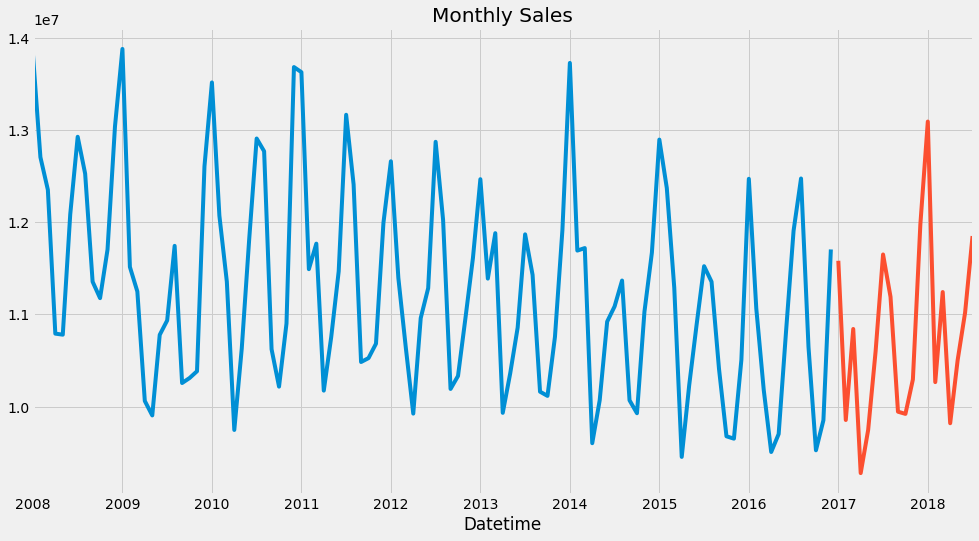

In [4]:
train=monthly_df.loc['2008':'2016'].copy()
test=monthly_df.loc['2017':'2018'].copy()
train.energy.plot(figsize=(15,8), title= 'Monthly Sales', fontsize=14)
test.energy.plot(figsize=(15,8), title= 'Monthly Sales', fontsize=14)

## 1. Naive Method: Let's pretend whatever was the last value will repeat itself in the future.

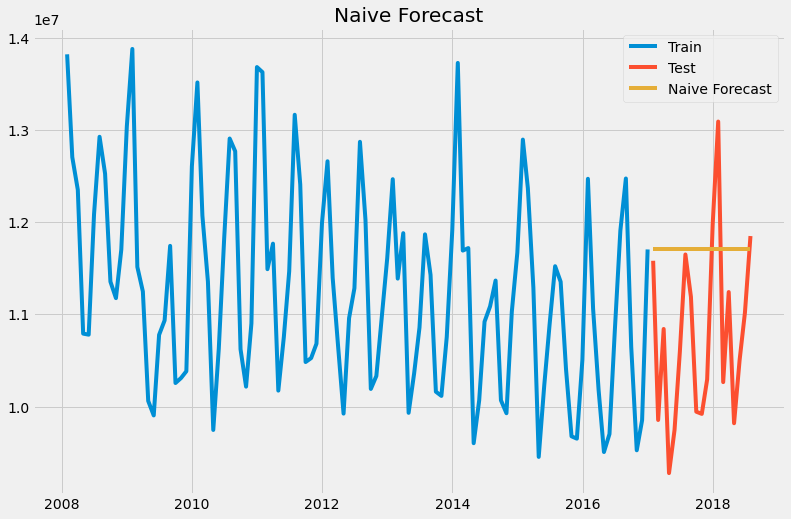

In [5]:
preds=test.copy()
preds['naive']=train[-1:].values[0][0]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['energy'], label='Train')
plt.plot(test.index,test['energy'], label='Test')
plt.plot(preds.index,preds['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast");

In [6]:
rms_naive = round(sqrt(mean_squared_error(test.energy, preds.naive)),2)
results.loc['naive']=rms_naive
results

,rmse
naive,1325608.56


## 2. Simple Average: Let's pretend that the future will offer the mean value of our past historywhatever was the last value will repeat itself in the future.

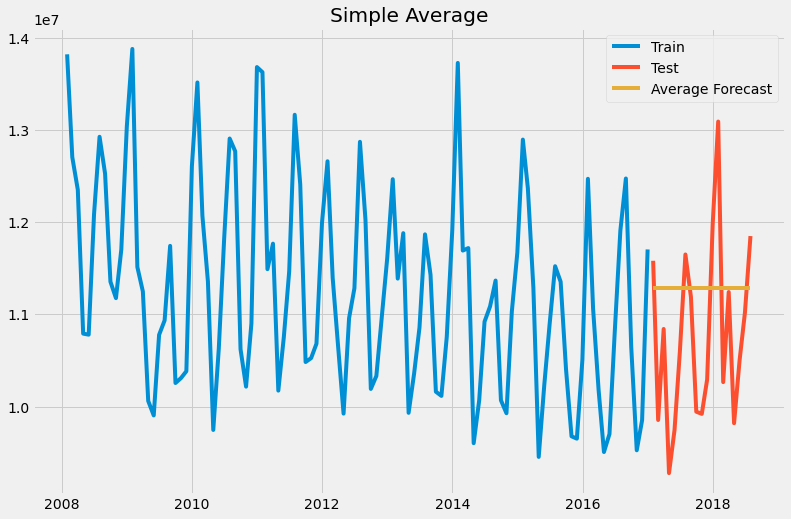

In [7]:
preds['average']=train.energy.mean()
plt.figure(figsize=(12,8))
plt.plot(train.index, train['energy'], label='Train')
plt.plot(test.index,test['energy'], label='Test')
plt.plot(preds.index,preds['average'], label='Average Forecast')
plt.legend(loc='best')
plt.title("Simple Average");

In [8]:
rms_average = round(sqrt(mean_squared_error(test.energy, preds.average)),2)
results.loc['simple_average']=rms_average
results=results.sort_values('rmse')
results

,rmse
simple_average,1072483.57
naive,1325608.56


## 3. Moving Average: Let's pretend that the future will offer the mean value of our past historywhatever was the last value will repeat itself in the future.

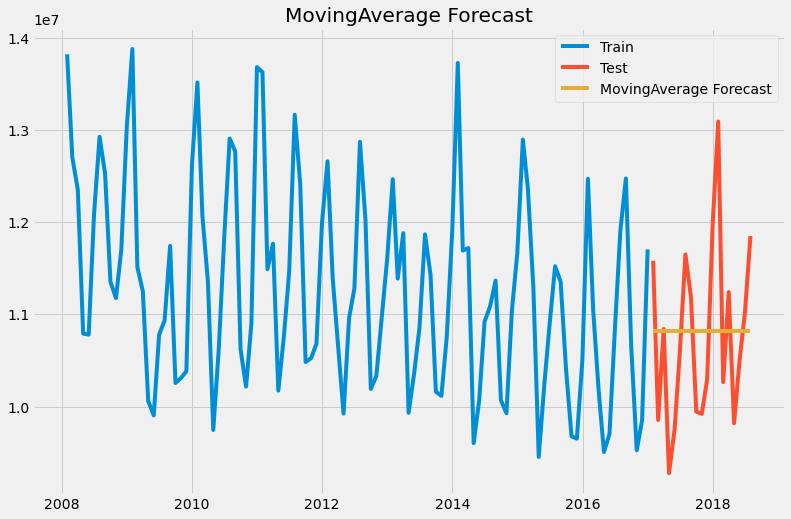

In [9]:
preds['moving_average']=train.energy.rolling(12).mean().iloc[-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['energy'], label='Train')
plt.plot(test.index,test['energy'], label='Test')
plt.plot(preds.index,preds['moving_average'], label='MovingAverage Forecast')
plt.legend(loc='best')
plt.title("MovingAverage Forecast");

In [10]:
rms_ma = round(sqrt(mean_squared_error(test.energy, preds.moving_average)),2)
results.loc['moving_average']=rms_ma
results=results.sort_values('rmse')
results

,rmse
moving_average,944047.61
simple_average,1072483.57
naive,1325608.56


## 4. Simple Exponential Smoothing: We are giving different weights to the values depending on time. THe earlier the value occurs the less weight ity is given.

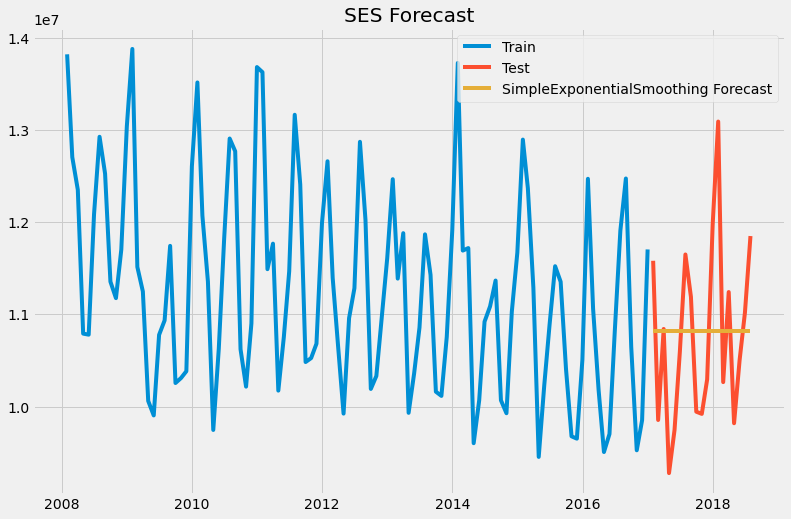

In [11]:
fit2 = SimpleExpSmoothing(train.energy).fit(smoothing_level=0.6,optimized=False)
preds['SimpleExponentialSmoothing'] = fit2.forecast(len(test))
plt.figure(figsize=(12,8))
plt.plot(train.index, train['energy'], label='Train')
plt.plot(test.index,test['energy'], label='Test')
plt.plot(preds.index,preds['moving_average'], label='SimpleExponentialSmoothing Forecast')
plt.legend(loc='best')
plt.title("SES Forecast");

In [12]:
rms_ses = round(sqrt(mean_squared_error(test.energy, preds.SimpleExponentialSmoothing)),2)
results.loc['SES']=rms_ses
results=results.sort_values('rmse')
results

,rmse
moving_average,944047.61
SES,974246.68
simple_average,1072483.57
naive,1325608.56



## 5. Holt's Linear Trend: We are adding the trend to the SES to make forecasts

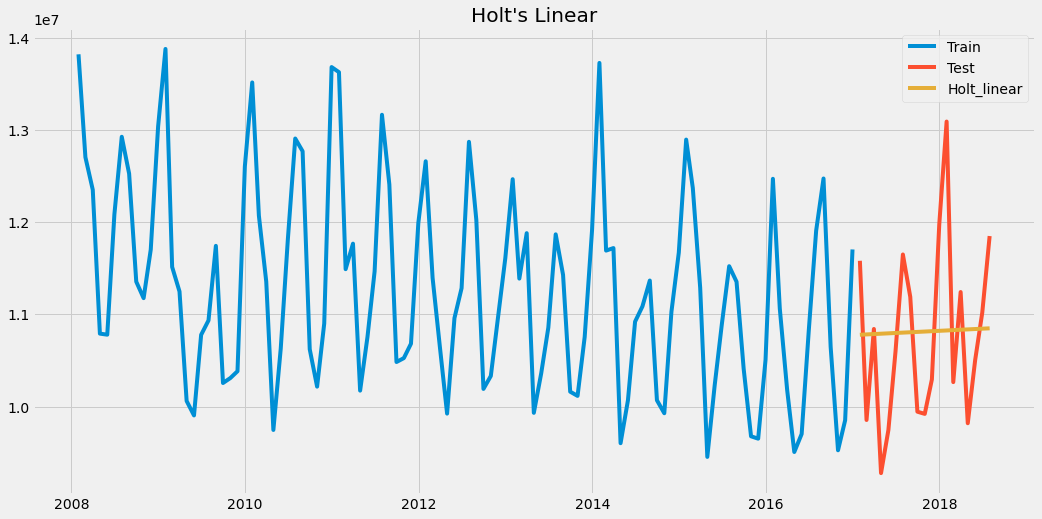

In [14]:
fit1 = Holt(train.energy).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
preds['holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train.energy, label='Train')
plt.plot(test.energy, label='Test')
plt.plot(preds['holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.title("Holt's Linear");
plt.show()

In [15]:
rms_holt = round(sqrt(mean_squared_error(test.energy, preds.holt_linear)),2)
results.loc['holt_linear']=rms_holt
results=results.sort_values('rmse')
results

,rmse
holt_linear,938473.78
moving_average,944047.61
SES,974246.68
simple_average,1072483.57
naive,1325608.56


## 6. Holt's Winter: Let's add the seasonality to make forecasts

/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


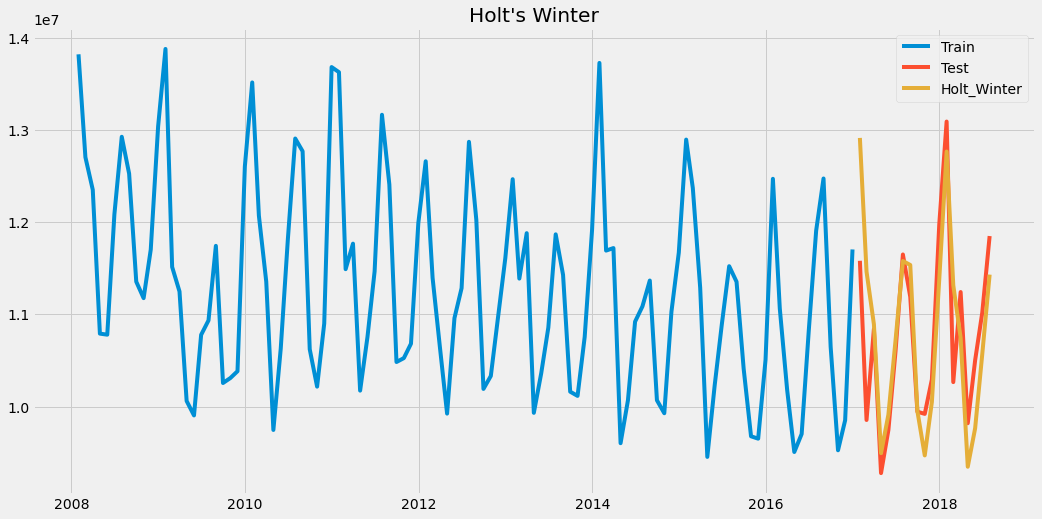

In [16]:

fit1 = ExponentialSmoothing(train.energy ,seasonal_periods=12 ,trend='add', seasonal='add',).fit()
preds['holt_winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train.energy, label='Train')
plt.plot(test.energy, label='Test')
plt.plot(preds.holt_winter, label='Holt_Winter')
plt.legend(loc='best')
plt.title("Holt's Winter");
plt.show()

In [17]:
rms_holtwinter = round(sqrt(mean_squared_error(test.energy, preds.holt_winter)),2)
results.loc['holt_winter']=rms_holtwinter
results=results.sort_values('rmse')
results

,rmse
holt_winter,640244.45
holt_linear,938473.78
moving_average,944047.61
SES,974246.68
simple_average,1072483.57
naive,1325608.56


## 7: ARIMA---AR for AutoRegressive, I for Integrated and MA for moving average

In [20]:
with open('best_parameters.pkl', 'rb') as f:
    bp=pickle.load(f)
bp['monthly']

[(2, 2, 2), (2, 2, 0, 12)]

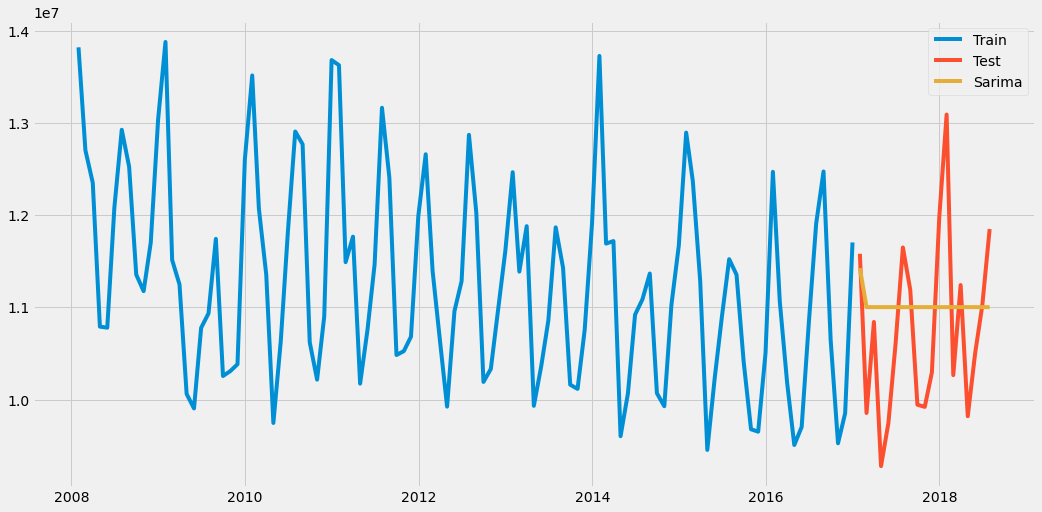

In [18]:
model = ARIMA(train.energy, order=(0, 1, 2))
model_fit = model.fit()
# make prediction
preds['arima'] = model_fit.predict(start = len(train), end =len(train)+len(test), dynamic= True)
plt.figure(figsize=(16,8))
plt.plot( train.energy, label='Train')
plt.plot(test.energy, label='Test')
plt.plot(preds.arima, label='Sarima')
plt.legend(loc='best')
plt.show()

In [19]:
rms_arima = round(sqrt(mean_squared_error(test.energy, preds.arima)),2)
results.loc['arima']=rms_arima
results=results.sort_values('rmse')
results

,rmse
holt_winter,640244.45
holt_linear,938473.78
moving_average,944047.61
arima,962103.54
SES,974246.68
simple_average,1072483.57
naive,1325608.56


## 8: SARIMA. Adding seasonality to ARIMA

In [23]:
bp['monthly']

[(2, 2, 2), (2, 2, 0, 12)]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37714D+01    |proj g|=  2.88860D+00


 This problem is unconstrained.



At iterate    5    f=  1.30250D+01    |proj g|=  1.21068D-02

At iterate   10    f=  1.30241D+01    |proj g|=  4.94556D-02

At iterate   15    f=  1.30230D+01    |proj g|=  1.22144D-02

At iterate   20    f=  1.30171D+01    |proj g|=  5.17032D-01

At iterate   25    f=  1.29857D+01    |proj g|=  5.97464D-01

At iterate   30    f=  1.29831D+01    |proj g|=  3.91764D-02

At iterate   35    f=  1.29824D+01    |proj g|=  1.21747D-02

At iterate   40    f=  1.29823D+01    |proj g|=  1.11044D-01

At iterate   45    f=  1.29802D+01    |proj g|=  9.88300D-02

At iterate   50    f=  1.29796D+01    |proj g|=  8.57540D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


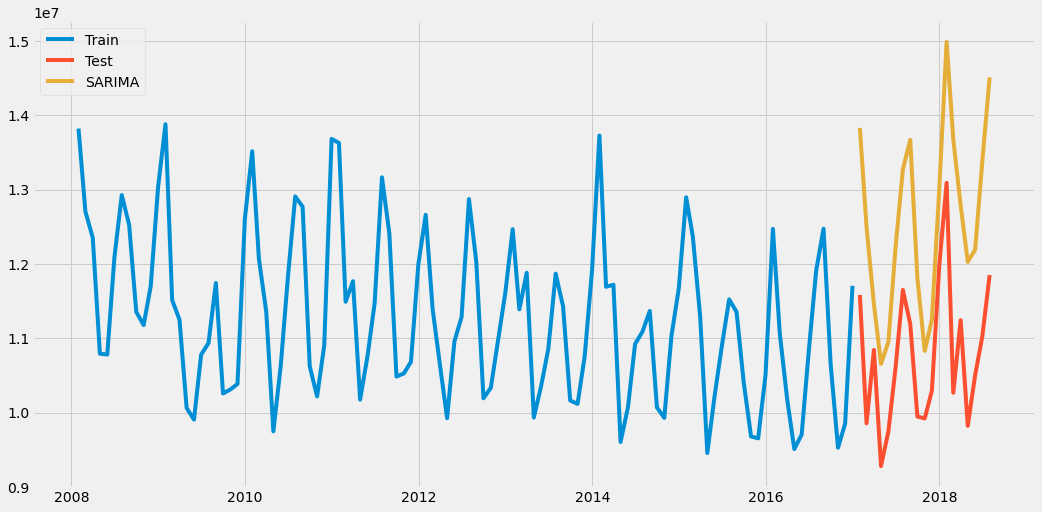

In [24]:
#(0, 1, 2), (0, 1, 2, 12)
#(2, 2, 2), (2, 2, 0, 12)
fit1 = sm.tsa.statespace.SARIMAX(train.energy, order=(2, 1, 2),seasonal_order=(2, 1, 0, 12)).fit()
preds['sarima'] = fit1.predict(start = len(train), end =len(train)+len(test), dynamic= True)
plt.figure(figsize=(16,8))
plt.plot( train.energy, label='Train')
plt.plot(test.energy, label='Test')
plt.plot(preds.sarima, label='SARIMA')
plt.legend(loc='best')
plt.show()

In [25]:
rms_sarima = round(sqrt(mean_squared_error(test.energy, preds.sarima)),2)
results.loc['sarima']=rms_sarima
results=results.sort_values('rmse')
results

,rmse
holt_winter,640244.45
holt_linear,938473.78
moving_average,944047.61
arima,962103.54
SES,974246.68
simple_average,1072483.57
naive,1325608.56
sarima,1937700.93


## 9: Prophet. Asking for help to FaceBook.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02481
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       608.787   0.000477776       661.511      0.9103      0.9103      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       610.302    0.00161122       565.143      0.4529           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280       611.038   5.11673e-06       176.101   1.676e-08       0.001      364  LS failed, Hessian reset 
     299       611.064     6.555e-05       117.186           1           1      387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       611.424   0.000141705       242.167       1.436      0.1436      508   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       611.561   2.04347e-05    

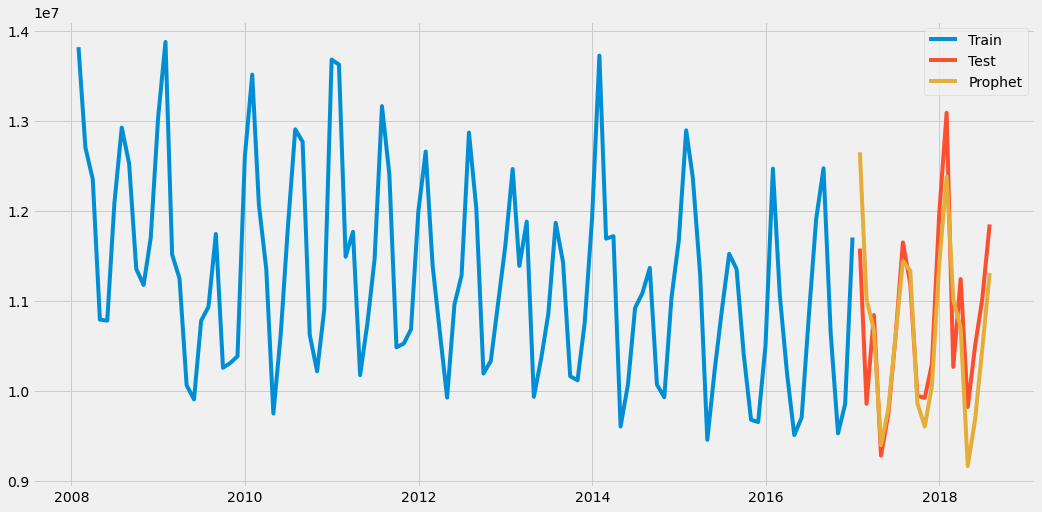

In [26]:
#Prophet

seasonality=12

freq='M'
####Prepping for Prophet
pro_train=train.reset_index()

pro_train.rename(columns={'energy':'y','Datetime':'ds'}, inplace = True)

pro_train['y'] = np.log(pro_train['y'])
model = Prophet()
model.fit(pro_train)
future = model.make_future_dataframe(periods=len(test), freq = 'M')
forecast = model.predict(future)
pro_preds=forecast.set_index('ds').yhat.tail(len(test)).values
preds['fbp_preds']=np.exp(pro_preds)
plt.figure(figsize=(16,8))
plt.plot( train.energy, label='Train')
plt.plot(test.energy, label='Test')
plt.plot(preds.fbp_preds, label='Prophet')
plt.legend(loc='best')
plt.show()

In [27]:
rms_prophet = round(sqrt(mean_squared_error(test.energy, preds.fbp_preds)),2)
results.loc['prophet']=rms_prophet
results=results.sort_values('rmse')
results

,rmse
prophet,568170.97
holt_winter,640244.45
holt_linear,938473.78
moving_average,944047.61
arima,962103.54
SES,974246.68
simple_average,1072483.57
naive,1325608.56
sarima,1937700.93


In [28]:
results.to_csv('scores.csv')